In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from joblib import Parallel, delayed
import sys
sys.path.append('../sloth/')
from sloth import *
from definitions import *
from utils import *

device = 'cpu'
d=3 #Sloth dimensions
n_rs = 20 #different fits of sloth
rot = 'geomin_obl'

colors = ["blue", "white", "red"]#, "black"
colormap = "coolwarm" #LinearSegmentedColormap.from_list("GreenRed", colors)

holdout_names = ['gemma-7b','meta-llama-3-70b-instruct','pythia-12b']
todelete_names = ['gemma-7b-it','meta-llama-3-70b'] #wont be used in any way

Loading data

In [2]:
data_test_time, models = np.load("../data/test_time_scaling_data.npy", allow_pickle=True).item().values()
data, D, X, Y, Cs, Y_names = load_data(todelete_names=todelete_names)

In [3]:
np.unique(list(data.Model))

array(['bloom-1b1', 'bloom-3b', 'bloom-560m', 'bloom-7b1',
       'blossom-v5.1-34b', 'dolly-v2-12b', 'dolly-v2-7b',
       'dolphin-2.9.1-yi-1.5-34b', 'dolphin-2.9.1-yi-1.5-9b',
       'falcon-40b', 'falcon-7b', 'falcon-7b-instruct', 'gemma-2b',
       'gemma-2b-it', 'gemma-7b', 'gpt-neo-1.3b', 'gpt-neo-2.7b',
       'llama-13b', 'llama-2-13b', 'llama-2-13b-chat', 'llama-2-70b',
       'llama-2-70b-chat', 'llama-2-7b', 'llama-2-7b-chat',
       'llama-3-sauerkrautlm-8b-instruct', 'llama-65b', 'llama-7b',
       'meta-llama-3-70b-instruct', 'meta-llama-3-8b',
       'meta-llama-3-8b-instruct', 'olmo-1b', 'olmo-7b', 'openhermes-13b',
       'openhermes-7b', 'opt-1.3b', 'opt-30b', 'orca-2-13b', 'orca-2-7b',
       'orca_mini_v3_13b', 'orca_mini_v3_7b', 'pythia-12b', 'pythia-160m',
       'pythia-2.8b', 'pythia-410m', 'pythia-6.9b', 'qwen1.5-0.5b',
       'qwen1.5-0.5b-chat', 'qwen1.5-1.8b', 'qwen1.5-1.8b-chat',
       'qwen1.5-14b', 'qwen1.5-14b-chat', 'qwen1.5-32b',
       'qwen1.5-32b-

In [4]:
models

['meta-llama-3-8b-instruct',
 'meta-llama-3-8b',
 'meta-llama-3-70b-instruct',
 'gemma-2b',
 'gemma-7b',
 'pythia-160m',
 'pythia-410m',
 'pythia-2.8b',
 'pythia-6.9b',
 'pythia-12b']

Getting train and test indices

In [5]:
Models_dict = {k: v for v, k in enumerate(list(data['Model']))}
test_ind = []
for model in holdout_names:
    test_ind.append(Models_dict[model])
test_ind.sort()
train_ind = [i for i in range(X.shape[0]) if i not in test_ind]

In [6]:
test_ind

[14, 27, 40]

Training Sloth using training set

In [7]:
def fit_sloth(random_seed):
    model = Sloth(d)
    model.fit(X[train_ind], D[train_ind], Y[train_ind], Cs, fit_C=False, train_link=False, positive_w=False, verbose=False, random_seed=random_seed)
    return model, random_seed

sloths = Parallel(n_jobs=-1, verbose=2)(delayed(fit_sloth)(random_seed) for random_seed in range(n_rs))
sloth = sloths[np.argmin([sloth[0].best_loss for sloth in sloths])][0]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  2.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished


Retrieving loading and other stuff from Sloth

In [8]:
anchor = 1 #to guarantee similar pattern on L to what is presented in the main plots of the paper
L_rot = sloth.interpret(anchor,rot)['loadings']
B_rot = sloth.interpret(anchor,rot)['B']
Delta = sloth.interpret(anchor,rot)['translation']

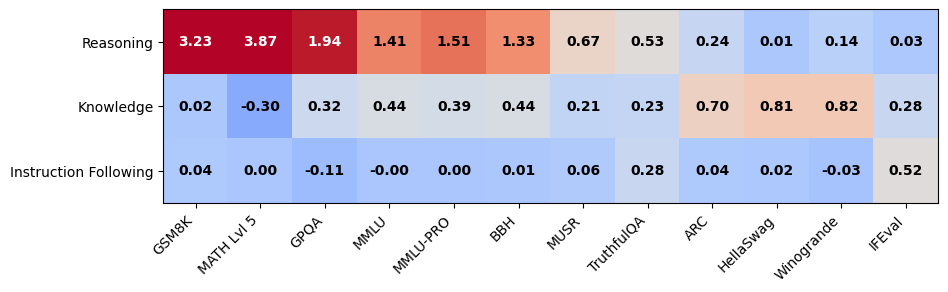

In [9]:
vmin=-1
vmax=2

factor_labels = ['Reasoning',
                 'Knowledge',
                 'Instruction Following']

plt.figure(figsize=(10, 6))  # Set the figure size (width, height) in inches
plt.imshow(L_rot, cmap=colormap, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(len(Y_names)), labels=Y_names, rotation=45, ha="right")  # Set the x-tick labels
plt.yticks(np.arange(d), labels=factor_labels, rotation=0, ha="right")  # Set the y-tick labels

inter = [-.3,1.6]
for i in range(len(L_rot)):
    for j in range(len(L_rot.T)):
        value = L_rot[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = plt.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#

plt.savefig(f'../plots/loadings_testscaling.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()

Prep data to train IRT model

In [10]:
train_models = [m for m in models if m not in (holdout_names+todelete_names)]
indices = np.array([np.argmax(np.array([m for i,m in enumerate(data.Model) if i in train_ind])==model) for model in train_models])
Z_train = sloth.interpret(anchor,rot)['skills']
Z_train = Z_train[indices]
Z_test = np.hstack((X[test_ind], D[test_ind]))@B_rot-Delta
Y_train = torch.tensor(data_test_time[[i for i,m in enumerate(models) if m in train_models]]).float()
Models_dict = {k: v for v, k in enumerate(models)}
Y_test = data_test_time[[Models_dict[m] for m in holdout_names]]

In [11]:
holdout_names

['gemma-7b', 'meta-llama-3-70b-instruct', 'pythia-12b']

In [12]:
Z_train.shape,Z_test.shape

((7, 3), (3, 3))

Training IRT

In [13]:
#hyperparams
weight_decays=[1e-1,1e-3,1e-5,0]
lr = 1.
scale = .0001
eps=1e-10
random_seed=42
sigmoid = nn.Sigmoid()

#creating train/val masks
validation_fraction = .1
train_mask = create_irt_train_mask(Y_train, validation_fraction)
val_mask = ~train_mask
n_train = train_mask.sum()
n_val = val_mask.sum()

In [14]:
dim_irt = Z_train.shape[1]

losses = []
val_losses = []
alphas_irt = []
betas_irt = []

for weight_decay in tqdm(weight_decays):
    torch.manual_seed(random_seed)
    theta_irt = torch.tensor(Z_train, requires_grad=False).float()
    alpha_irt = nn.Parameter(torch.normal(torch.tensor(0.), torch.tensor(scale), size=(data_test_time.shape[1], dim_irt), device=device))
    beta_irt = nn.Parameter(torch.normal(torch.tensor(0.), torch.tensor(scale), size=(data_test_time.shape[1],), device=device))
    optimizer = torch.optim.LBFGS([alpha_irt, beta_irt], lr=lr, max_iter=50, history_size=10)
    
    def closure():
        optimizer.zero_grad()
        Y_hat = sigmoid((theta_irt @ alpha_irt.T) - beta_irt[None, :])[:, :, None]
        reg = ((alpha_irt.norm()**2)+(beta_irt.norm()**2))/(np.prod([s for s in alpha_irt.shape]) + np.prod([s for s in beta_irt.shape]))
        loss_matrix = -(Y_train * torch.log(Y_hat + eps) + (1 - Y_train) * torch.log(1 - Y_hat + eps))
        loss = (loss_matrix * train_mask).sum() / n_train + weight_decay*reg
        loss.backward()
        return loss
    loss = optimizer.step(closure)
    with torch.no_grad():
        Y_hat = sigmoid((theta_irt @ alpha_irt.T) - beta_irt[None, :])[:, :, None]
        loss_matrix = -(Y_train * torch.log(Y_hat + eps) + (1 - Y_train) * torch.log(1 - Y_hat + eps))
        val_loss = (loss_matrix * val_mask).sum() / n_val
        val_losses.append(val_loss.item())
    
    alphas_irt.append(alpha_irt.detach().numpy())
    betas_irt.append(beta_irt.detach().numpy())

print("val losses",val_losses)
alpha_irt = alphas_irt[np.argmin(val_losses)]
beta_irt = betas_irt[np.argmin(val_losses)]

  0%|          | 0/4 [00:00<?, ?it/s]

val losses [0.2001028060913086, 0.14224836230278015, 0.14160065352916718, 0.14160850644111633]


In [15]:
np.mean(alpha_irt<0)

0.21614583333333334

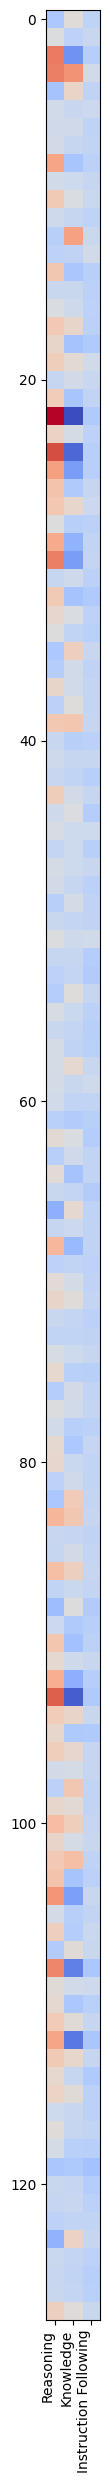

In [16]:
plt.figure(figsize=(15, 30))  # Set the figure size (width, height) in inches
plt.imshow(alpha_irt, cmap=colormap)
plt.xticks(np.arange(d), labels=factor_labels, rotation=90, ha="right")  # Set the y-tick labels
plt.show()

In [17]:
alpha_irt.mean(0)

array([1.1908466 , 0.38991484, 0.15493652], dtype=float32)

Computing pass@k and plotting

In [18]:
Y_test.shape

(3, 128, 10000)

In [19]:
probs = sigmoid_np(Z_test@alpha_irt.T-beta_irt[None,:])

def coverage_hat_func(k):
    return 1-((1-probs)**k).mean(-1)

def coverage_func(k):
    return Y_test[:,:,:k].max(-1).mean(-1)

def pass_at_k(n, c, k): #https://arxiv.org/pdf/2107.03374
    """
    :param n: total number of samples
    :param c: number of correct samples
    :param k: k in pass@$k$
    """
    if n - c < k: return 1.0
    return 1.0 - np.prod(1.0 - k /np.arange(n - c + 1, n + 1))

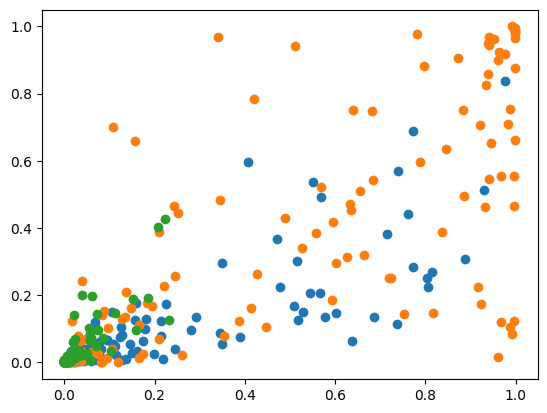

In [20]:
for i in range(probs.shape[0]):
    plt.scatter(Y_test.mean(-1)[i],probs[i])

In [21]:
n = Y_test.shape[-1]
coverage = np.array([coverage_func(k) for k in tqdm(range(1,n+1))]).squeeze()
coverage_pass_at_k = np.array([[np.mean([pass_at_k(Y_test.shape[-1], c, k) for c in Y_test[i,:,:].sum(-1)]) for k in tqdm(range(1,n+1))] for i in range(Y_test.shape[0])]).squeeze().T
coverage_hat = np.array([coverage_hat_func(k) for k in tqdm(range(1,n+1))]).squeeze()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

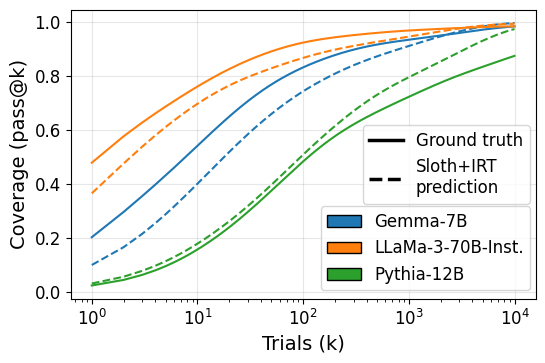

In [44]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

plt.figure(figsize=(6, 3.75))  # Adjust width and height as needed

labels = {'gemma-7b': 'Gemma-7B', 'meta-llama-3-70b-instruct': 'LLaMa-3-70B-Inst.', 'pythia-12b': 'Pythia-12B'}
colors = {'gemma-7b': '#1f77b4', 'meta-llama-3-70b-instruct': '#ff7f0e', 'pythia-12b': '#2ca02c'}

# Plot the data
for i, m in enumerate(holdout_names):
    plt.plot(range(1, n + 1), coverage_pass_at_k[:, i], '-', color=colors[m], label=f'{labels[m]}')
    plt.plot(range(1, n + 1), coverage_hat[:, i], '--', color=colors[m], label=f'{labels[m]} (Approximation)')

# Create custom legend handles for line types
solid_line = Line2D([0], [0], color='black', linestyle='-', linewidth=2.5, label='Ground truth')
dashed_line = Line2D([0], [0], color='black', linestyle='--', linewidth=2.5, label='Sloth+IRT\nprediction')

# Create custom legend handles for model colors (using patches)
model_handles = [
    Patch(facecolor=color, edgecolor='black', label=f'{labels[m]}')  # Use Patch for rectangular legend
    for m, color in colors.items()
]

# Combine legends in the bottom-left corner
line_legend = plt.legend(handles=[solid_line, dashed_line], fontsize=12, bbox_to_anchor=(0.61, .3), 
                         loc='lower left', frameon=True)
model_legend = plt.legend(handles=model_handles, fontsize=12, bbox_to_anchor=(0.52, -0), 
                          loc='lower left', frameon=True)

# Add the line type legend back after adding the second one
plt.gca().add_artist(line_legend)

# Axis settings
plt.xscale('log')
plt.ylabel('Coverage (pass@k)', fontsize=14)
plt.xlabel('Trials (k)', fontsize=14)

# Ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)

# Save and Show
plt.savefig('../plots/curves_testscaling.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()
